In [9]:
import sys
sys.path.append('../')

import photonqat as pq

In [10]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt

## Photonqat

基本的なゲート動作と測定を一通り行っています。

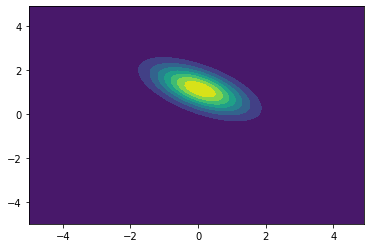

measured x = 1.3195217596926831
mu0 = [0.05666782 1.12897311]
cov0 = [[ 0.79001283 -0.38079708]
 [-0.38079708  0.5       ]]


In [35]:
G = pq.Gaussian_trans(2) # two qumode [0, 1]
G.Displace(0, 2) # Displacement gate, x to x+2
G.Xsqueeze(0, 1) # X squeeIng gate, r=1
G.rotation(0, np.pi/4) # pi/4 rotation gate
G.BS(0, 1, np.pi/4) # 50:50 beam splitter
x = G.MeasureX(1) # Measure mode 1
G.plotGaussianWigner(0) # plot
print('measured x =', x)
print('mu0 =', G.mean(0)) # mu of qumode 0
print('cov0 =', G.cov(0)) # covarince of qumode 1

## Strawberry Fields

上のコードと同様の操作をしています。  
MeasureXで$\hat{x}$を測定した際の測定値がガウス分布からのランダムサンプリングなので、実行のたび異なります。  
測定されたqumodeは(現実には測定により光は検出器に吸収されて無くなりますが便宜上)、vacume stateにしています。  
それ以外のqumodeは測定によって、

- 共分散行列は測定値に依存せず変化する
- 平均は測定値に依存して変化する

ため、共分散行列は上のコードと出力が常に同じであるべきですが、平均は独立同分布なサンプル点がそれぞれ得られます。

measured x = 1.3392834887705678
mu0 = [ 0.99531466 -0.10350332]
cov0 = [[ 0.79001282 -0.38079709]
 [-0.38079709  0.50000001]]


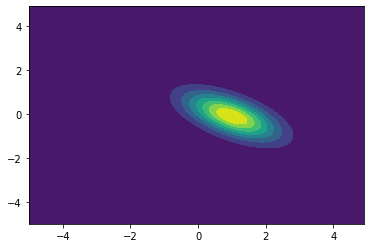

In [13]:
eng = sf.Engine(backend="gaussian")
gaussian = sf.Program(2)

with gaussian.context as q:
        sf.hbar = 1
        # prepare the initial states
        Dgate(2) | q[0] # displacement gate
        Sgate(1) | q[0] # position squeezed
        Rgate(np.pi/4) | q[0] # rotation gate
        BSgate(np.pi/4, 0) | (q[0], q[1])  # 50-50 beamsplitter

        # perform the homodyne measurements
        MeasureX | q[1]

results = eng.run(gaussian)
mu0, cov0 = results.state.reduced_gaussian([0])
mu1, cov1 = results.state.reduced_gaussian([1])
print('measured x =',  q[1].val)
print('mu0 =', mu0)
print('cov0 =', cov0)

x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
W = results.state.wigner(0, x, p)
X, P = np.meshgrid(x, p)
plt.contourf(X, P, W)

## 以下、メモ

## Phase space について

N bosonic mode Hilbert space  
$\otimes^{N}_{k=1} \mathcal{H}_k$

vectorial operator  
$\hat{\mathbf{b}} = (\hat{a}_1, \hat{a}_1^{\dagger}, \dots, \hat{a}_N, \hat{a}_N^{\dagger})$ : 2N elements

bosonic commutation relations  
$[\hat{b}_i, \hat{b}_j] = \Omega_{ij}\ \ (i, j = 1, \dots, 2N)$ 

$\mathbf{\Omega} = \oplus_{k=1}^{N}\omega\ \ \ 
\omega = 
\begin{pmatrix}
0 & 1 \\
-1 & 0 \\
\end{pmatrix}
$

Quadrature field  
$\hat{\mathbf{x}} = (\hat{q}_1, \hat{p}_1, \dots, \hat{q}_N, \hat{p}_N)$ : 2N elements

canonical commutation relation  
$[\hat{x}_i, \hat{x}_j] = 2i\Omega_{ij}\ \ (i, j = 1, \dots, 2N)$ 

## 密度演算子とWigner関数

任意の密度演算子$\hat{\rho}$を考える  

任意の密度演算子は等価なWigner関数が存在する

Weyl operator  
$D(\xi) = \exp(i \hat{x}^T \Omega \hat{\xi})$  

これを用いて、Wigner characteristic functionを定義できる  
$\chi (\xi) = \mathrm{Tr}[\hat{\rho}D(\xi)]$

Wigner characteristic functionのフーリエ変換がWigner function  
$W(\mathbf{x}) = \int_{R^{2N}} \frac{d^{2N}}{(2\pi)^{2N}} \exp{(-i \hat{x}^T \Omega \hat{\xi})} \chi (\xi)$

## 統計量とWigner関数

Wigner functionは統計量でも定義できる  

- first moment  
$\bar{\mathbf{x}} = \langle \hat{\mathbf{x}} \rangle= \mathrm{Tr}[\hat{\mathbf{x}} \hat{\rho}]$

- second moment  
$V_{ij} = \frac{1}{2}\langle \{\Delta\hat{x}_i, \Delta\hat{x}_j \}\rangle$  
$\{ A, B \} = AB+BA$

$V_{ii}$は$\hat{x}_i$の分散をあらわす

Gaussian stateは最初の2モーメントだけで完全に記述可能

## Gaussian Unitaryについて

Quadrature operatorにおいては、Gaussian UnitaryはAffien写像で書ける！  
$(\mathbf{S}, \mathbf{d}) : \hat{\mathrm{x}}\to \mathbf{S}\mathrm{x} + \mathbf{d}$

Williamson's Theorem  
任意の偶数次元の正定値実行列はsimplectic transformで対角化できる  
$\mathbf{V} = \mathbf{SV}^{\oplus}\mathbf{S}^{T}$  
$\mathbf{V}^{\oplus} = \oplus^{N}_{k=1} \nu_k \mathbf{I}$

## Gaussian Measurement  

POVM: $\Pi_i = E_{i}^{\dagger}E_i\ \ \ (\sum_i E_{i}^{\dagger}E_i = I)$  
これを連続量に置き換える  

Gaussian Measurementとは、Gaussian stateに対して行い、出力結果がGaussian Distributionで、測定しなかったモードはGaussian stateのままである

測定するsubsystemを$\mathbf{B}$として、それ以外のsubsystemを$\mathbf{A}$とする。

測定結果の確率分布：測定モード以外の直交位相を周辺化したGaussian Wigner分布  
測定後の状態：以下のようになる.


$\mathbf{V} = \mathbf{A} - \mathbf{C}(\mathbf{\Pi B \Pi})^{-1}\mathbf{C}^T$  
$\mathbf{\Pi} = \rm{diag}(1, 0)$     ($\hat{x}$測定の場合)

$\mathbf{\Pi B \Pi}$は非正則。pseudo-inverseを用いる。  
$(\mathbf{\Pi B \Pi})^{-1} = B_{11}^{-1}\Pi$

これは多変量ガウス分布の条件付き分布をとるのと基本的に同じ  
なので同様に測定後の状態の平均もとれる

$\mathbf{\mu} = \mathbf{\mu_A} - \mathbf{C}(\mathbf{\Pi B \Pi})^{-1}(\mathbf{\mu_B} - x_B\mathbf{\Pi})$